# Optimal filter tutorial
This script demonstrates how the optimal filtering is typically done. Using a preloaded set pulses and noise data. 

We first load the optimal_filter.py file with the relevant functions + some necessary packages:

In [1]:
from optimal_filter import *

import matplotlib.pyplot as plt
from scipy.fft import ifft
import numpy as np

%matplotlib widget

Then, we load the two data inputs: a stack of pulses and a noise timestream

In [2]:
pulses = np.load('pulses.npy')    # MxN array of M pulses of length N
noise = np.load('noise.npy')      # 3 sec of timestream noise data taken at 1 Msample/sec

We then initialize some parameters

In [3]:
pw = 1024                           # pulse window length
len_onesided = round(pw / 2) + 1    # length of the onesided fft, this includes the DC and Nyquist term.
sf = 1e6                            # sampling frequency of data
exclude_dc = True                   # whether or not to exclude the DC value of the pulse and noise models in the optimal filter
nr_req_segments = 1000              # how many noise segments we want to average for our noise model. It may be that less are returned than desired because of pulses present in the noise data.
threshold = None                    # threshold for pulse detection in the the noise data 

We then compute our pulse and noise models, as well as a normalisation constant

In [4]:
norm_pulse, norm_pulse_fft, norm_pulse_psd = pulse_model(pulses, pw, sf)
noise_psd, freqs = noise_model(noise, pw, sf, threshold=None, nr_req_segments=1000)
filter = optimal_filter(norm_pulse_fft, noise_psd, exclude_dc)

Now we compute the optimal pulse heights

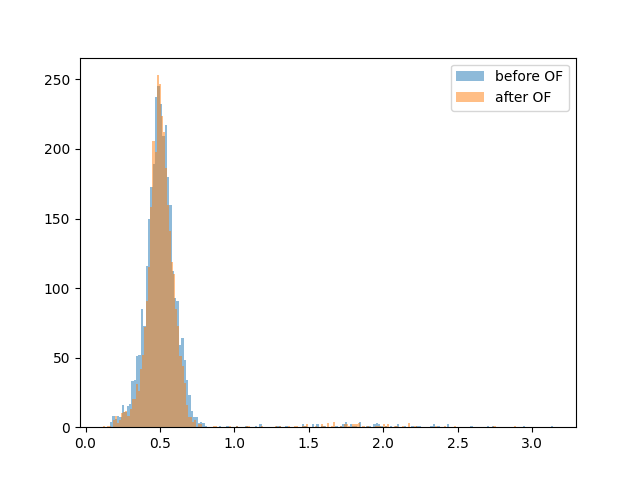

In [15]:
H = []
dt = []
for pulse in pulses:
    Hopt = pulse_height(pulse, len_onesided, filter, exclude_dc) # this is everthing that should be done with the mux
    H.append(Hopt)
fig, ax = plt.subplots()
_ = ax.hist(np.amax(pulses, axis=1), bins='auto', alpha=0.5, label='no OF, simply taking the maximum')
_ = ax.hist(H, bins='auto', alpha=0.5, label='with OF')
ax.legend()

We plot all the various pulse and noise model and apply them to a single noisy pulse:

In [6]:
pulse_nr = 534                              # choose a pulse
noisy_pulse = pulses[pulse_nr, :]           # noisy pulse
opt_pulse = H[pulse_nr]*norm_pulse          # optimal pulse
fft_noisy_pulse = fft(noisy_pulse)[exclude_dc:len_onesided]
opt_pulse_fft = fft_noisy_pulse * filter

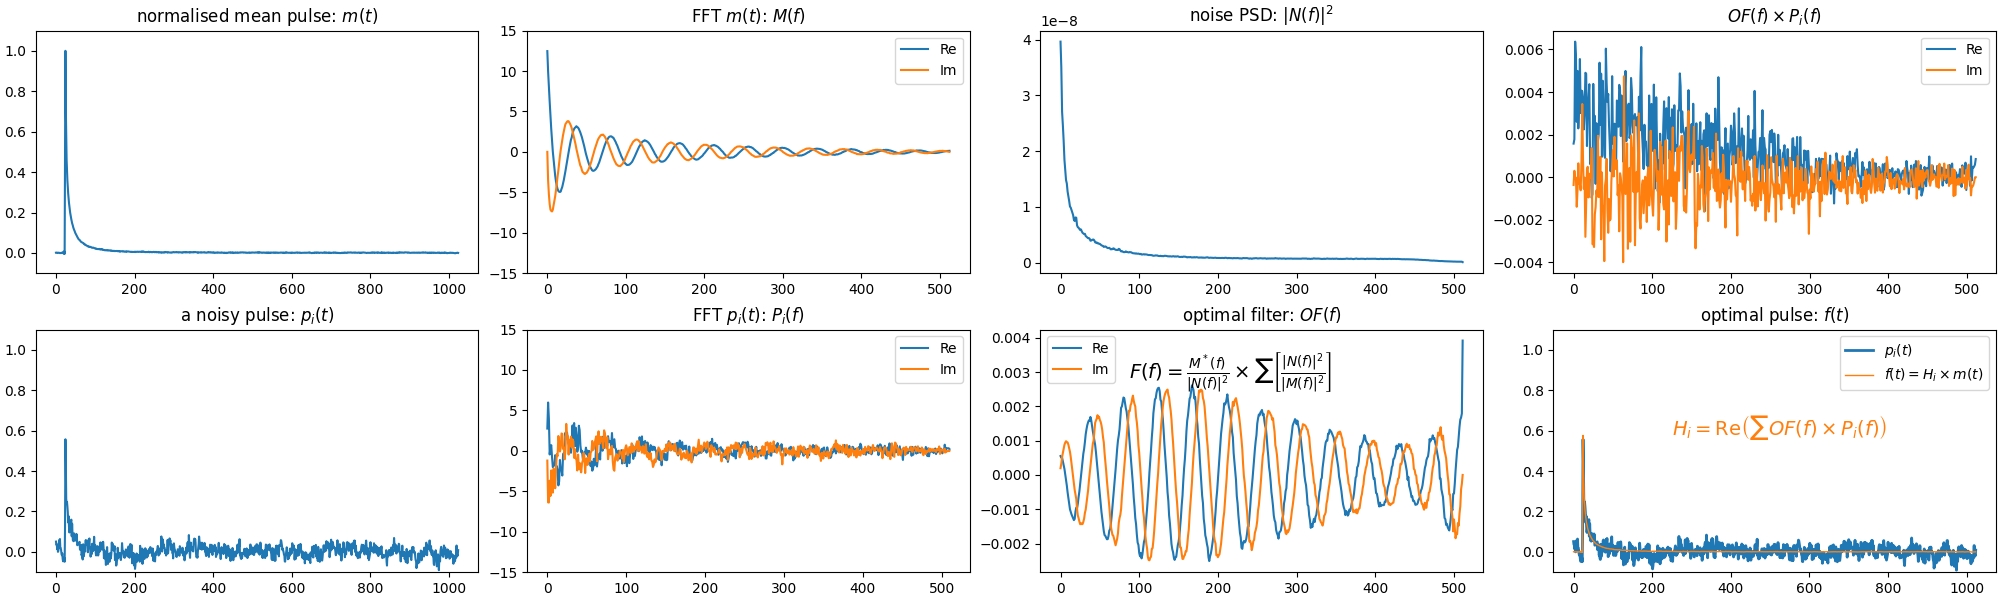

In [7]:
fig, axes = plt.subplot_mosaic('abcg;defh', figsize=(20, 6), sharey=False, constrained_layout=True)
ax = axes['a']
ax.plot(norm_pulse)
ax.set_ylim([-.1, 1.1])
ax.set_title('normalised mean pulse: $m(t)$')

ax = axes['b']
ax.plot(norm_pulse_fft.real, label='Re')
ax.plot(norm_pulse_fft.imag, label='Im')
ax.set_ylim([-15, 15])
ax.legend()
ax.set_title('FFT $m(t)$: $M(f)$')

ax = axes['c']
ax.plot(noise_psd[exclude_dc:])
ax.set_title('noise PSD: $|N(f)|^2$')

ax = axes['d']
ax.plot(noisy_pulse)
ax.set_ylim([-.1, 1.1])
ax.set_title('a noisy pulse: $p_i(t)$')

ax = axes['e']
ax.plot(fft_noisy_pulse[exclude_dc:].real, label='Re')
ax.plot(fft_noisy_pulse[exclude_dc:].imag, label='Im')
ax.legend()
ax.set_title('FFT $p_i(t)$: $P_i(f)$')
ax.set_ylim([-15, 15])

ax = axes['f']
ax.plot(filter.real, label='Re')
ax.plot(filter.imag, label='Im')
ax.set_title('optimal filter: $OF(f)$')
ax.text(.2, .8, '$F(f) = \\frac{M^*(f)}{|N(f)|^2}\\times\sum\left[\\frac{|N(f)|^2}{|M(f)|^2}\\right]$', color='k', transform=ax.transAxes, fontsize=14)
ax.legend()

ax = axes['g']
ax.plot(opt_pulse_fft.real, label='Re')
ax.plot(opt_pulse_fft.imag, label='Im')
ax.set_title('$OF(f)\\times P_i(f)$')
ax.legend()

ax = axes['h']
ax.plot(noisy_pulse, label='$p_i(t)$', lw=2)
ax.plot(opt_pulse, label='$f(t) = H_i \\times m(t)$', lw=1)
ax.text(250, H[pulse_nr], '$H_i = \\rm Re\\left(\sum \it OF(f) \\times P_i(f) \\right)$', color='tab:orange', fontsize=14)
ax.set_title('optimal pulse: $f(t)$')
ax.legend()
_ = ax.set_ylim([-.1, 1.1])


In [ ]:
# def expulse(t, tau):
#     return np.exp(-t/tau)

# t = np.arange(pw-100)
# pulse = expulse(t, 100)
# pulse = np.hstack((np.zeros(100), pulse))
# fft_pulse = fft(pulse)[:len_onesided]
# fig, axes = plt.subplot_mosaic('ab', figsize=(10, 3))
# ax = axes['a']
# ax.plot(pulse)
# ax = axes['b']
# ax.plot(fft_pulse.real)
# ax.plot(fft_pulse.imag)